In [21]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

**Pre-processing**

In [22]:
path = "C:/Users/User/Desktop/Assignatures/Synthesis project/elliptic_bitcoin_dataset"

df_classes = pd.read_csv(path+'/elliptic_txs_classes.csv')
df_edges = pd.read_csv(path+'/elliptic_txs_edgelist.csv')
df_features = pd.read_csv(path+'/elliptic_txs_features.csv', header=None)

In [23]:
# Change column names of df_features
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)
df_features

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


In [24]:
# Pass unknown to number 3
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3
print('Label 1 belongs to illicit transactions, label 2 to licit transactions and label 3 to unknown transactions.\n')
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Label 1 belongs to illicit transactions, label 2 to licit transactions and label 3 to unknown transactions.

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


In [25]:
# Merge the DataFrames on the column 'source', assuming it's the same name in both DataFrames
df_merged = pd.merge(df_features, df_classes, on='txId', how='left')
df_merged

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,3
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,3
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,3
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,3
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,3
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3


**Generating grahps**

In [26]:
def generate_graph(df, df_edges, save_graph = False, filename = None, path = None):
    i= 0
    # Create an empty graph
    G = nx.Graph()

    for _, row in df.iterrows():
        # Extract node ID and attributes
        print(i)
        node_id = row['txId']
        node_attributes = row.drop('txId').to_dict()
        
        # Add node to the graph with its attributes
        G.add_node(node_id, **node_attributes)
        i+= 1
        
    i=0
    # Add edges to the graph
    for _, row in df_edges.iterrows():
        G.add_edge(row['txId1'], row['txId2'])
        i+=1
        
    if save_graph:
        # Save the graph as a pickle file
        with open(filename, "wb") as f:
            pkl.dump(G, f)
            
        # Specify the path to the pickle file
        pickle_file_path = path + filename

        # Open the pickle file in binary mode
        with open(pickle_file_path, 'rb') as f:
            # Load the data from the pickle file
            G = pkl.load(f)
    
    return G

In [ ]:
path_file = 'C:/Users/Usuario/Desktop/UAB/Tercer/2n cuatri/Synthesis project/GraphAnomaly/'
graph = generate_graph(df_merged, df_edges, save_graph=True, filename="elipticData_G.pkl", path=path_file)

In [ ]:
def create_subgraph(graph, df, timestep):
    for value in  range(max(df['Time step'])):
        if value == timestep:
            # Create a list of nodes that have the desired value in the specified feature
            desired_nodes = [node for node, data in graph.nodes(data=True) if data.get("Time step") == value+1]
            sub_G = graph.subgraph(desired_nodes)
            
            return sub_G

In [ ]:
subgraph = create_subgraph(graph, df_features, timestep=29)

In [ ]:
def draw_graph(graph):
    nx.draw(graph, with_labels=False, node_color='skyblue', node_size=20, font_size=12)
    plt.show()

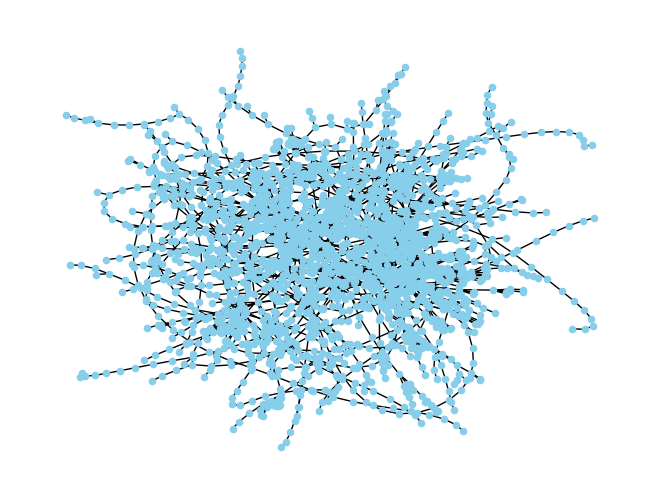

In [ ]:
draw_graph(subgraph)

**Machine Learning algorithms**

##### Handling unbalanced dataset

In [33]:
# Drop unknown nodes
num_50_50 = df_merged[df_merged['class'] != 3]

In [34]:
# A look at the balance of our data
print("Percentage of values of Ilicit(1) and Licit(2):")
(num_50_50['class'].value_counts()) / len(num_50_50)

Percentage of values of Ilicit(1) and Licit(2):


class
2    0.902392
1    0.097608
Name: count, dtype: float64

In [35]:
# num_50_50 is a smaller dataset that has the same amount of licit and ilicit nodes
num_50_50 = num_50_50.groupby('class', group_keys=False).apply(lambda x: x.sample(int(len(num_50_50)*0.097608), random_state=69))

In [32]:
# A look at the balance of our data
print("Percentage of values of Ilicit(1) and Licit(2):")
(num_50_50['class'].value_counts()) / len(num_50_50) * 100

Percentage of values of Ilicit(1), Licit(2) and Unknown(3):


class
1    50.0
2    50.0
Name: count, dtype: float64

##### Training models

In [64]:
class machineLearning:
    def __init__(self, df):
        self.df = df
        self.results = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F1 score"])
   
    def apply_PCA(self, ncomponents):
        # Standardize the features (important for PCA)
        scaler = StandardScaler()

        df_pca = self.df.drop(columns=['class'])
        scaled_data = scaler.fit_transform(df_pca)

        # Apply PCA
        pca = PCA(n_components=ncomponents)  # You can choose the number of components you want to keep
        principal_components = pca.fit_transform(scaled_data)

        # Create a DataFrame for the principal components
        columns = [f"PC{i+1}" for i in range(principal_components.shape[1])]
        principal_df = pd.DataFrame(data=principal_components, columns=columns)


        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = explained_variance_ratio.sum()

        print(f"\nExplained variance ratio: {cumulative_variance_ratio}")
        print(f"Data reduction, from shape {df_pca.shape} to {principal_df.shape}")
        
        # Add two columns to be able to apply ML models later on
        principal_df['txId'] = df_pca.index
        principal_df['class'] = list(num_50_50['class'])
        
        return principal_df
    
    
    def train_and_test(self, df_PCA, algorithm, display_conf_matrix=False):
        X = df_PCA.loc[df_PCA['class'].isin(['1', '2'])].drop(columns=['txId', 'class'])
        y = df_PCA.loc[df_PCA['class'].isin(['1', '2'])]['class']
        # print(set(list(principal_df.loc[principal_df['class'].isin(['1', '2'])]['class'])))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        print(f"\nTraining {algorithm}...\n")
        try:
            if algorithm == "Logistic regression":
                model = LogisticRegression()
                
            elif algorithm == "Random forest":
                model = RandomForestClassifier()
                
            elif algorithm == "SVM":
                model = SVC()
            
            elif algorithm == "Decision tree":
                model = DecisionTreeClassifier()
            
        except:
            return "Error! No machine learning model chosen."
        
        
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)
        
        print("Testing {algorithm}...\n")
        accuracy = round(accuracy_score(y_test, y_pred), 2)
        print("Accuracy: {:.2f}%".format(accuracy * 100))
        
        precision = round(precision_score(y_test, y_pred, pos_label='1'), 2)
        print("Precision: {:.2f}%".format(precision * 100))
        
        recall = round(recall_score(y_test, y_pred, pos_label='1'), 2)
        print("Recall: {:.2f}%".format(recall * 100))
        
        f1 = round(f1_score(y_test, y_pred, pos_label='1'),2)
        print("F1 Score: {:.2f}%".format(f1 * 100))
        
        self.results.loc[len(self.results)] = [algorithm, accuracy, precision, recall, f1]
        
        if display_conf_matrix:
            from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
            cm = confusion_matrix(y_test, y_pred, labels=['1', '2'])
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ilicit', 'Licit'])
            disp.plot()
            plt.title(algorithm)
            plt.show()


            # conf_matrix = confusion_matrix(y_test, y_pred)
            # plt.figure(figsize=(8, 6))
            # sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            #             xticklabels=model.classes_, 
            #             yticklabels=model.classes_)
            # plt.xlabel('Predicted Labels')
            # plt.ylabel('True Labels')
            # plt.title(f'Confusion Matrix for {algorithm}')
            # plt.show()
    
    def get_results(self):
        return self.results

In [65]:
methods = ["Logistic regression", "Decision tree", "Random forest", "SVM"]
#methods = ["Logistic regression"]
df_training = machineLearning(num_50_50)


Explained variance ratio: 0.9984640037224658
Data reduction, from shape (9090, 167) to (9090, 100)

Training Logistic regression...

Testing {algorithm}...

Accuracy: 89.00%
Precision: 85.00%
Recall: 93.00%
F1 Score: 89.00%


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


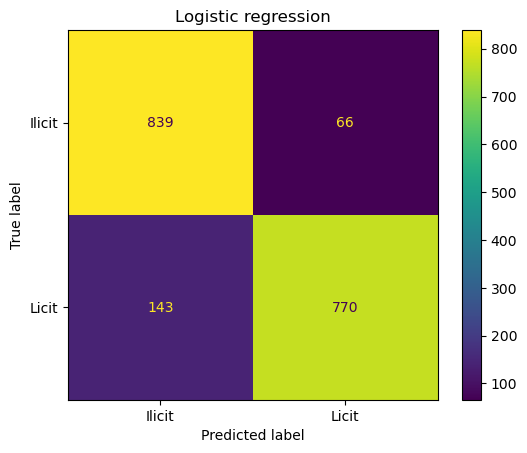


Explained variance ratio: 0.9984642250709609
Data reduction, from shape (9090, 167) to (9090, 100)

Training Decision tree...

Testing {algorithm}...

Accuracy: 88.00%
Precision: 88.00%
Recall: 87.00%
F1 Score: 87.00%


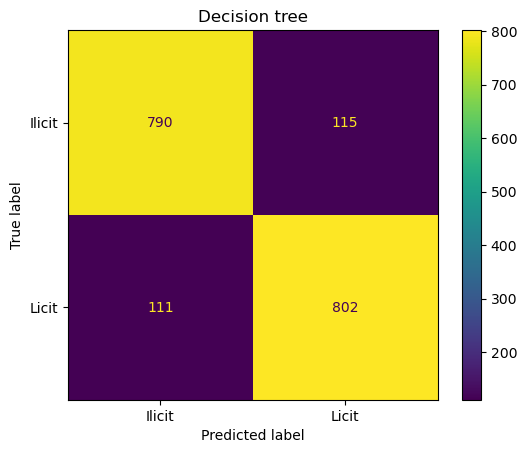


Explained variance ratio: 0.9984636812589799
Data reduction, from shape (9090, 167) to (9090, 100)

Training Random forest...

Testing {algorithm}...

Accuracy: 91.00%
Precision: 97.00%
Recall: 85.00%
F1 Score: 91.00%


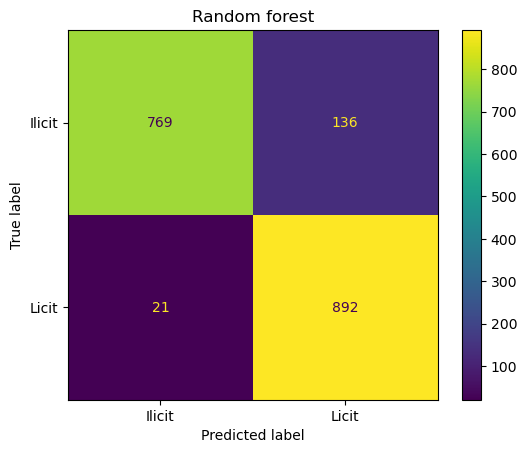


Explained variance ratio: 0.9984640382766967
Data reduction, from shape (9090, 167) to (9090, 100)

Training SVM...

Testing {algorithm}...

Accuracy: 92.00%
Precision: 93.00%
Recall: 90.00%
F1 Score: 92.00%


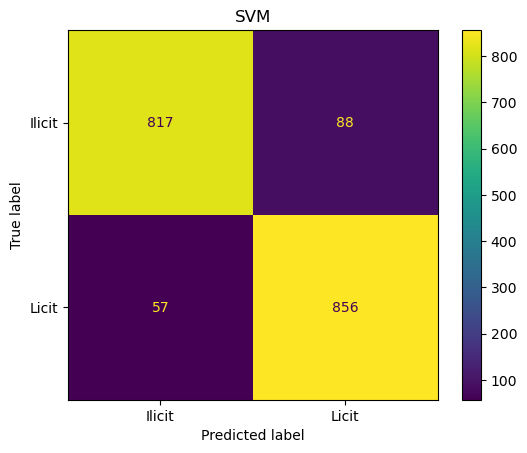

In [66]:
for method in methods:
    applied_PCA = df_training.apply_PCA(ncomponents=100)
    df_training.train_and_test(applied_PCA, method, display_conf_matrix=True)

In [62]:
results = df_training.get_results()

In [63]:
results

,Classifier,Accuracy,Precision,Recall,F1 score
0,Logistic regression,0.89,0.85,0.93,0.89
1,Decision tree,0.88,0.87,0.88,0.88
2,Random forest,0.91,0.97,0.85,0.91
3,SVM,0.92,0.93,0.90,0.92
